# Load Packages and Set Global Variables

## Imports and Settings

In [1]:
import anndata
import cellrank as cr
import numpy as np
import scanpy as sc
import scvelo as scv
import sys
import pandas as pd
import pickle
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

np.random.seed(seed=1)

In [2]:
import anndata
import batchglm.api as glm
import diffxpy.api as de
import patsy

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)

batchglm version v0.7.4
diffpy version v0.7.4


In [3]:
sc.settings.verbosity = 3 # amount of output

root_dir = '.'

dir_in = root_dir + 'data/'
base_dir = root_dir + 'results/'
dir_gene_sets = root_dir + 'data/gene_sets/MSigDBlists/'
dir_cc_gene_set = root_dir + 'data/gene_sets/regev_lab_cell_cycle_genes_10X.txt'

# Make sure that these folders exist:
dir_out = base_dir + 'figures/ahmo/'
dir_tables = base_dir + 'tables/ahmo/'
dir_anndata = base_dir + f'anndata/ahmo/'
dir_de = base_dir + 'de/ahmo/'

NJOBS = 6

sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, scanpy=True)
sc.settings.figdir = dir_out
scv.settings.figdir = dir_out
print(sys.version)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
2f7ece400a652629565c523b34ee61b04afa385c    NA
PIL                                         8.3.2
absl                                        NA
anyio                                       NA
appnope                                     0.1.2
astunparse                                  1.6.3
attr                                        21.2.0
babel                                       2.9.1
backcall                                    0.2.0
batchgl

In [4]:
constructs = [
    "Ascl1_transgene",
    "Hnf1a_transgene",
    "Myod1_transgene",
    "Pou5f1_transgene"
]
constructs_color_dict = {
    "DsRed": ['DsRed-Express-plus', 'DsRed-Express-minus'],
    "AcGFP1": ['AcGFP1-plus', 'AcGFP1-minus'],
    "EBFP2": ['EBFP2-plus', 'EBFP2-minus']
}
constructs_color = [
    "DsRed",
    "AcGFP1",
    "EBFP2"
]
endogenous_genes = [
    "Ascl1",
    "Hnf1a",
    "Myod1",
    "Pou5f1"
]

<a id="Global"></a>

## Global Variables


All embeddings and clusterings can be saved and loaded into this script. Be carful with overwriting cluster caches as soon as cell type annotation has started as cluster labels may be shuffled.

Set whether anndata objects are recomputed or loaded from cache.

In [5]:
bool_recomp = False

Set whether to produce plots, set to False for test runs.

In [6]:
bool_plot = True

# Load processed data

In [7]:
adata_proc = sc.read(dir_anndata+'adata_proc.h5ad') 

# Single-transfection condition overview

Summarise trends of marker genes across lineages in single-positive conditions,

In [8]:
def prepare_adata_by_lineage(
    adata, 
    tf, 
    assignment, 
    include_quiescent=False,
    include_others=["cycling", "cycling_transfected"],
    batch_correction=False
):
    if include_quiescent:
        ls_quiescent = ["quiescent"]
    else:
        ls_quiescent = []
    tf_lower = [x.lower() for x in tf]
    if assignment == "cluster":
        mask = np.array([
            x in include_others+tf_lower+ls_quiescent or np.any([xx in x for xx in tf_lower])
            for x in adata.obs["louvain_group"].values
        ])
    elif assignment == "construct_detection":
        mask = np.logical_or(
            np.any(adata.obs[[xx + "_transgene_positive" for xx in tf]].values, axis=1), 
            np.array([x in include_others+ls_quiescent
                      for x in adata.obs["louvain_group"].values])
        )
    elif assignment == "construct_detection_exclusive":
        mask = np.logical_or(
            np.any(adata.obs[[xx + "_transgene_positive" for xx in tf]].values, axis=1), 
            np.array([x in include_others+ls_quiescent
                      for x in adata.obs["louvain_group"].values])
        )
    elif assignment == "condition_positive":
        mask = np.logical_or(
            np.any(adata.obs[[xx + "_transgene_positive_condition" for xx in tf]].values, axis=1), 
            np.array([x in include_others+ls_quiescent
                      for x in adata.obs["louvain_group"].values])
        )
    elif assignment == "single_condition":
        ref_condition = np.unique([
            x for x in adata.obs["inferred_category_real"].values
            if x.split(")")[0] in ["15"]
        ])
        target_condition = np.unique([
            x for x in adata.obs["inferred_category_real"].values
            if x.split(")")[0] in ["1", "2", "3", "4"] and np.any([xx[:-1] in x.split(")")[1] for xx in tf])
        ])
        mask = np.array([x in [ref_condition, target_condition] for x in adata.obs["inferred_category_real"].values])
    else:
        assert False
    adata_temp = adata[mask].copy()
    categories = pd.Series(["none" for x in range(adata_temp.n_obs)])
    
    sc.pp.pca(adata_temp, n_comps=50, random_state=0, use_highly_variable=True, svd_solver='arpack')
    if batch_correction:
        sc.external.pp.bbknn(adata_temp, batch_key="batch_group", approx=True, metric='angular')
    else:
        sc.pp.neighbors(adata_temp, n_neighbors=20, knn=True, method='umap', n_pcs=50, random_state=0)
    sc.tl.umap(adata_temp)
    return adata_temp

In [9]:
adata_proc_Ascl1 = prepare_adata_by_lineage(
    adata_proc, tf=["Ascl1"],
    assignment="single_condition"
)
adata_proc_Myod1 = prepare_adata_by_lineage(
    adata_proc, tf=["Myod1"],
    assignment="single_condition"
)
adata_proc_Hnf1a = prepare_adata_by_lineage(
    adata_proc, tf=["Hnf1a"],
    assignment="single_condition"
)
adata_proc_Oct4 = prepare_adata_by_lineage(
    adata_proc, tf=["Pou5f1"], 
    assignment="single_condition"
)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['d

## Heatmaps ordered by TF concentration

In [13]:
def plot_heatmap(
    adata, 
    ref_list, 
    x, 
    max_log, 
    save, 
    obs_restriction={},
    cmap="Reds", 
    suffix="_transgene_norm_log"
):
    # Tailor the reference list of genes:
    print("not found: ")
    print([x for x in ref_list if x not in adata.var_names])
    ref_list = [x.lower() for x in ref_list]
    ref_list = [x for x in ref_list if x in adata.var_names]

    # Build anndata object for heatmap:
    adata_hm = anndata.AnnData(
        np.concatenate([
            np.expand_dims(
                adata.obs[x + suffix].values > np.max(adata.obs.loc[~adata.obs[x + "_transgene_positive"].values, x + suffix].values), 
                axis=1
            ),
            np.expand_dims(pd.get_dummies(adata.obs[x + "_transgene_positive"]).iloc[:, 0].values, axis=1)*max_log,
            np.log(adata.raw[:, ref_list].X.todense() / np.expand_dims(adata.obs["sf"].values, axis=1) + 1.),
        ], axis=1),
        obs=adata.obs
    )
    for k, v in obs_restriction.items():
        adata_hm = adata_hm[np.where([adata_hm.obs[k].values.astype(str) == v])[0], :].copy()
    adata_hm.var_names = ["assignment_boundary", "assignment"]+ref_list
    # define boundary
    sc.pl.heatmap(
        adata_hm, 
        ["assignment"]+ref_list, 
        groupby=x + suffix,
        use_raw=False, 
        log=False,
        cmap=cmap,
        show=True,
        save=save+".pdf" if save is not None else None
    )
    sc.pl.heatmap(
        adata_hm, 
        ["assignment"]+ref_list, 
        groupby=x + suffix,
        use_raw=False, 
        log=False,
        cmap="binary",
        show=True,
        save=save+"_cmap.pdf" if save is not None else None
    )
    return ref_list

In [14]:
def plot_density_along_lineage(adata, x, suffix="_transgene_norm_log"):
    for tp in np.unique(adata.obs["time"].values):
        sb.distplot(
            adata[adata.obs["time"].values == tp].obs[x + suffix].values,
            kde=True, label=tp
        )
    plt.legend()

### Ascl1

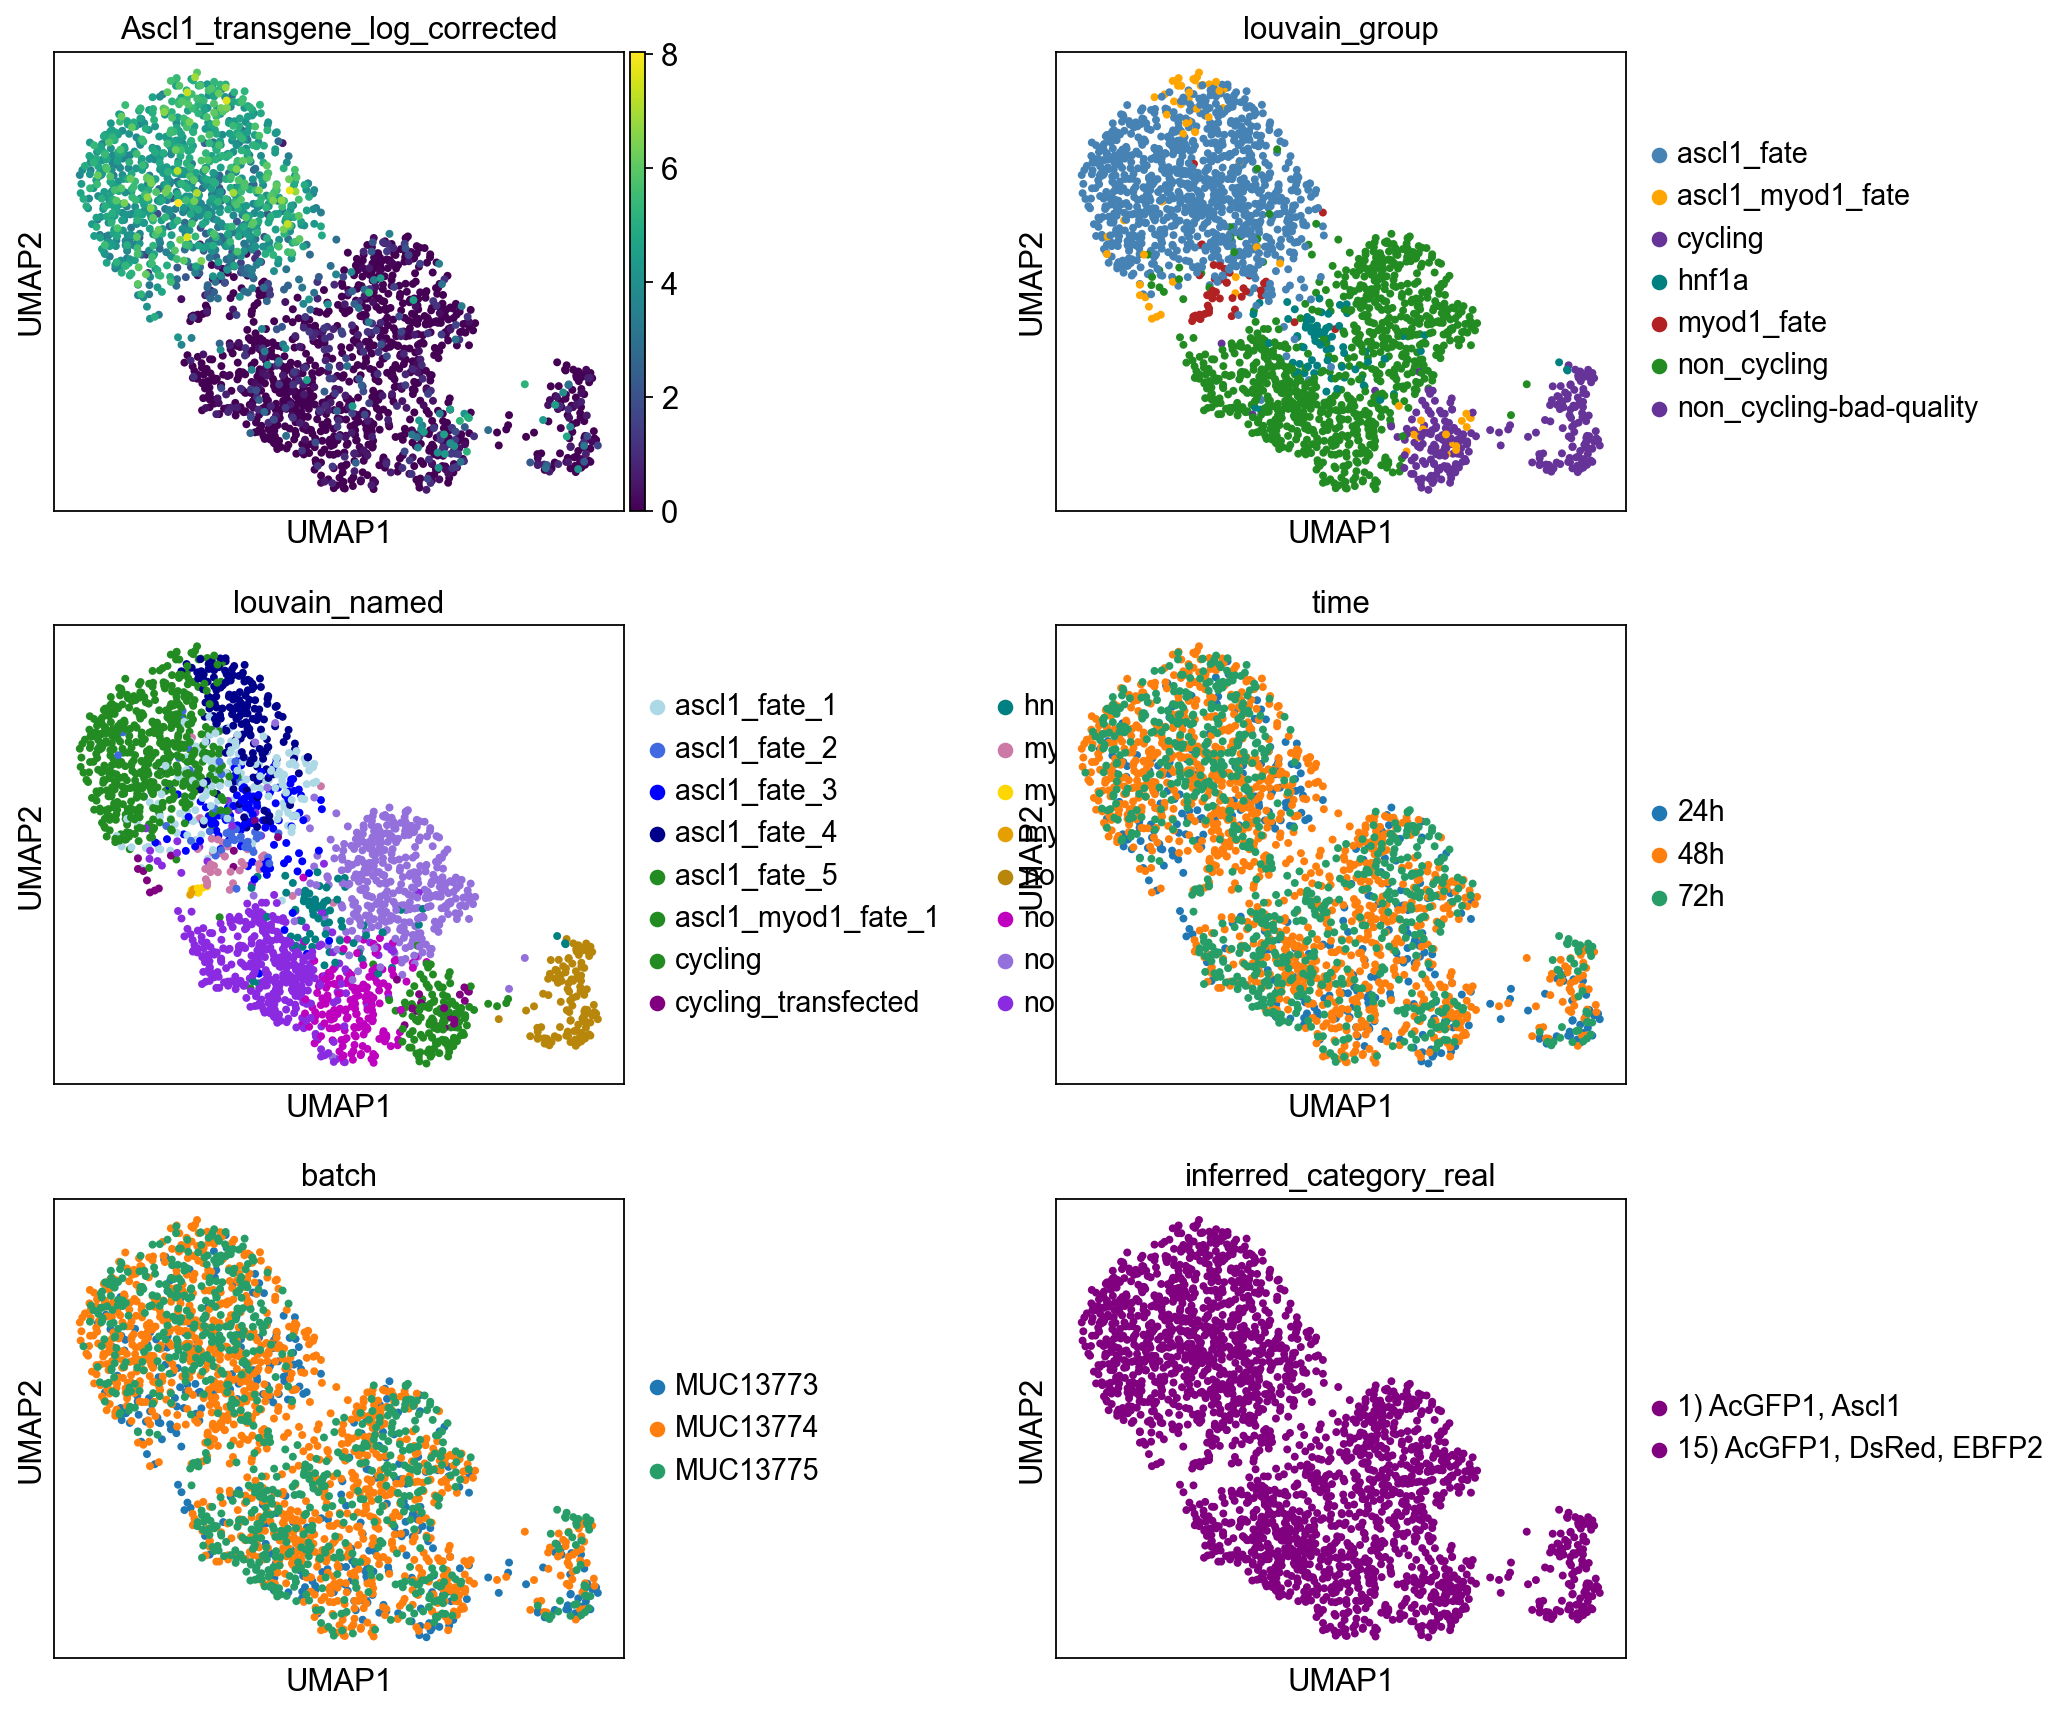

In [15]:
sc.pl.umap(adata_proc_Ascl1, color=[
    "Ascl1_transgene_log_corrected", 
    "louvain_group", "louvain_named", 
    "time", "batch",
    "inferred_category_real"
], wspace = 0.6, ncols=2)

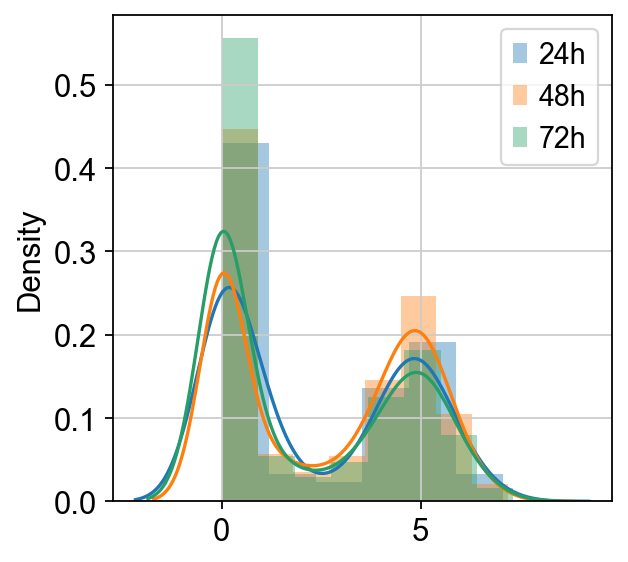

In [16]:
plot_density_along_lineage(adata=adata_proc_Ascl1, x="Ascl1", suffix="_transgene_norm_log_corrected")

In [17]:
Ascl1_ref_list_up = ['r3hdml', 'col18a1', 'hes6', 'stmn2', 'ucp2', 'lrrc17', 'mest', 'lpar1', 'lsp1', 'errfi1', 'bex1', 'nfia', 'fibin', 'tspan9', 'fabp5']
Ascl1_ref_list_down = ['galnt18', 'grem1', 'hmga2', 'serpine1', 'f3', 'akap12', 'actg2', 'ptgs2', 'ccn2', 'tinagl1', 'ngf', 'sprr2k', 'lmod1', 'fxyd5', 'loxl3']

not found: 
[]


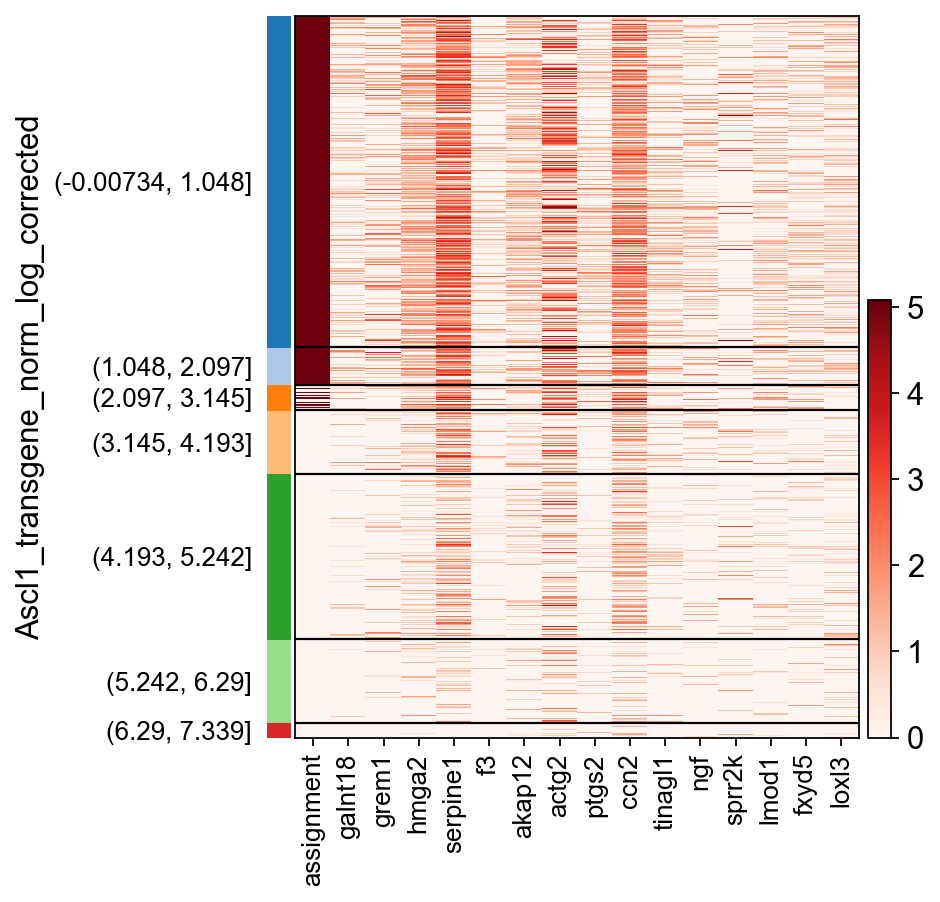

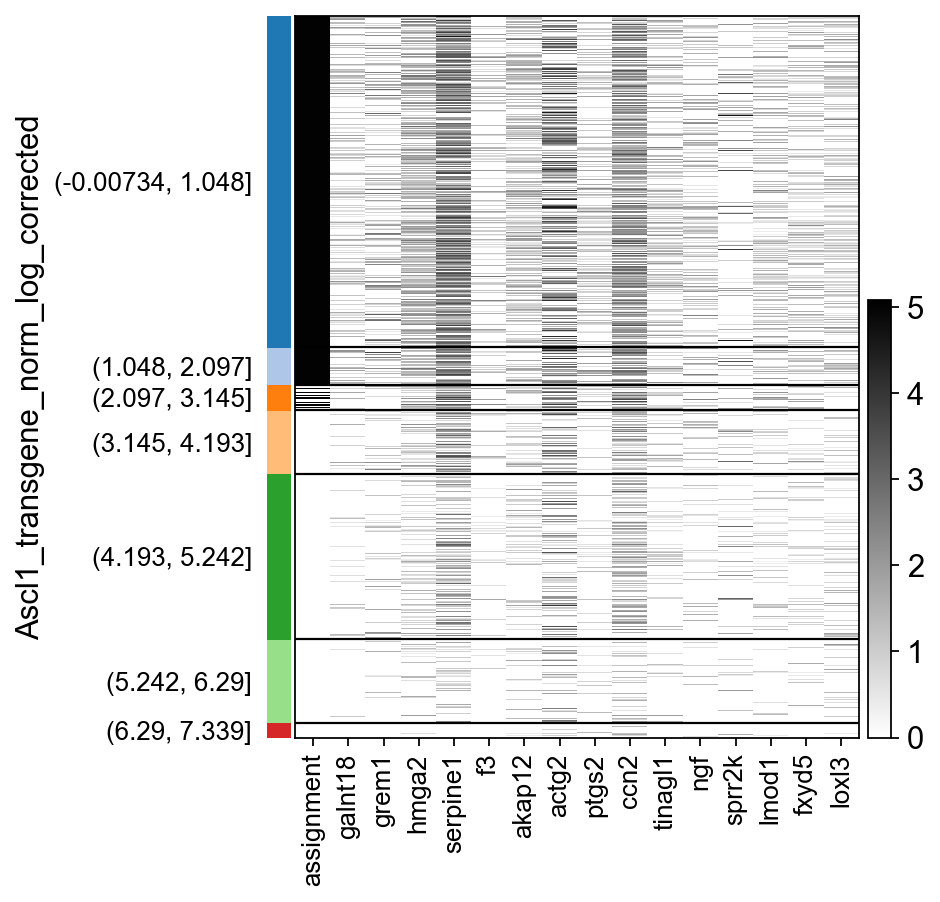

not found: 
[]


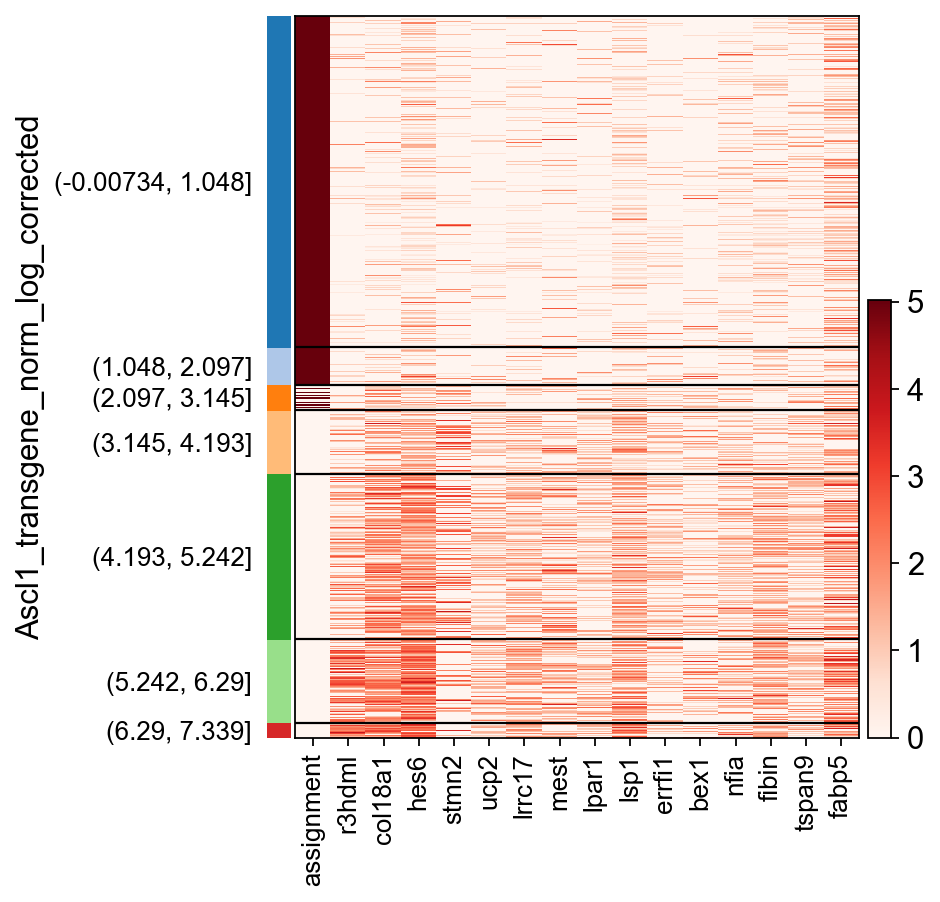

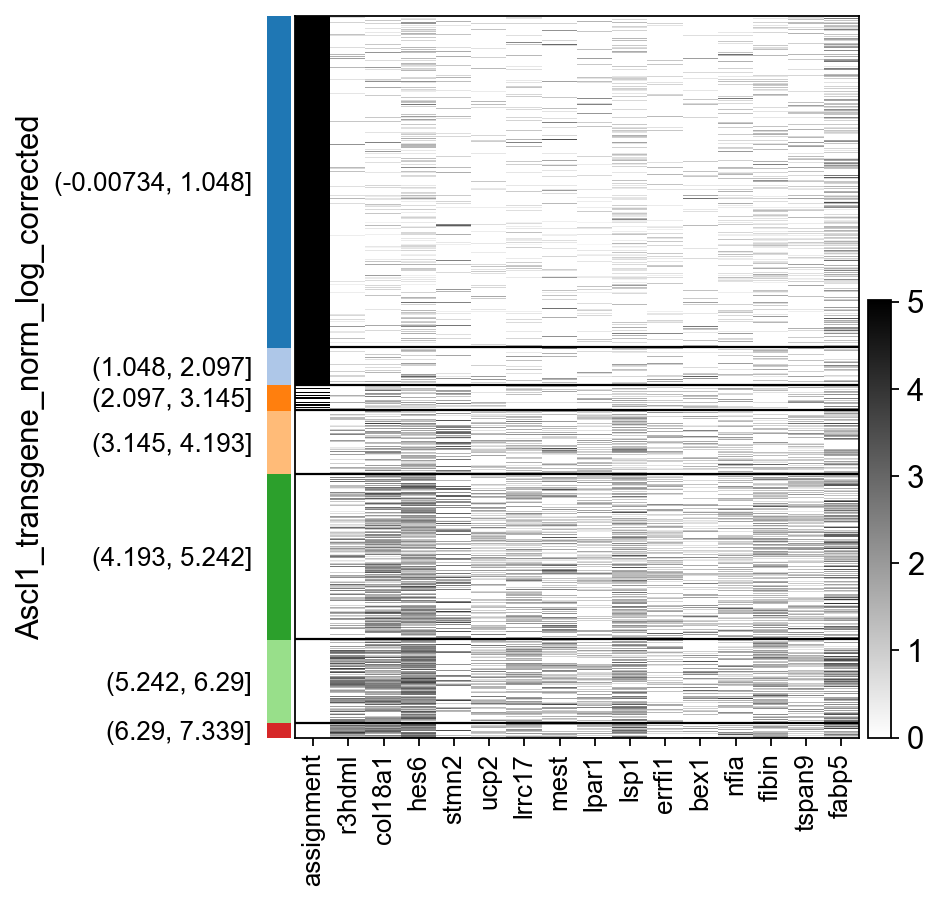

In [18]:
Ascl1_ref_list_clean = plot_heatmap(
    adata=adata_proc_Ascl1, 
    ref_list=Ascl1_ref_list_down, 
    x="Ascl1",
    suffix="_transgene_norm_log_corrected", 
    max_log=5,
    save=None
)
Ascl1_ref_list_clean = plot_heatmap(
    adata=adata_proc_Ascl1, 
    ref_list=Ascl1_ref_list_up, 
    x="Ascl1",
    suffix="_transgene_norm_log_corrected", 
    max_log=5,
    save=None
)

### HNF1a

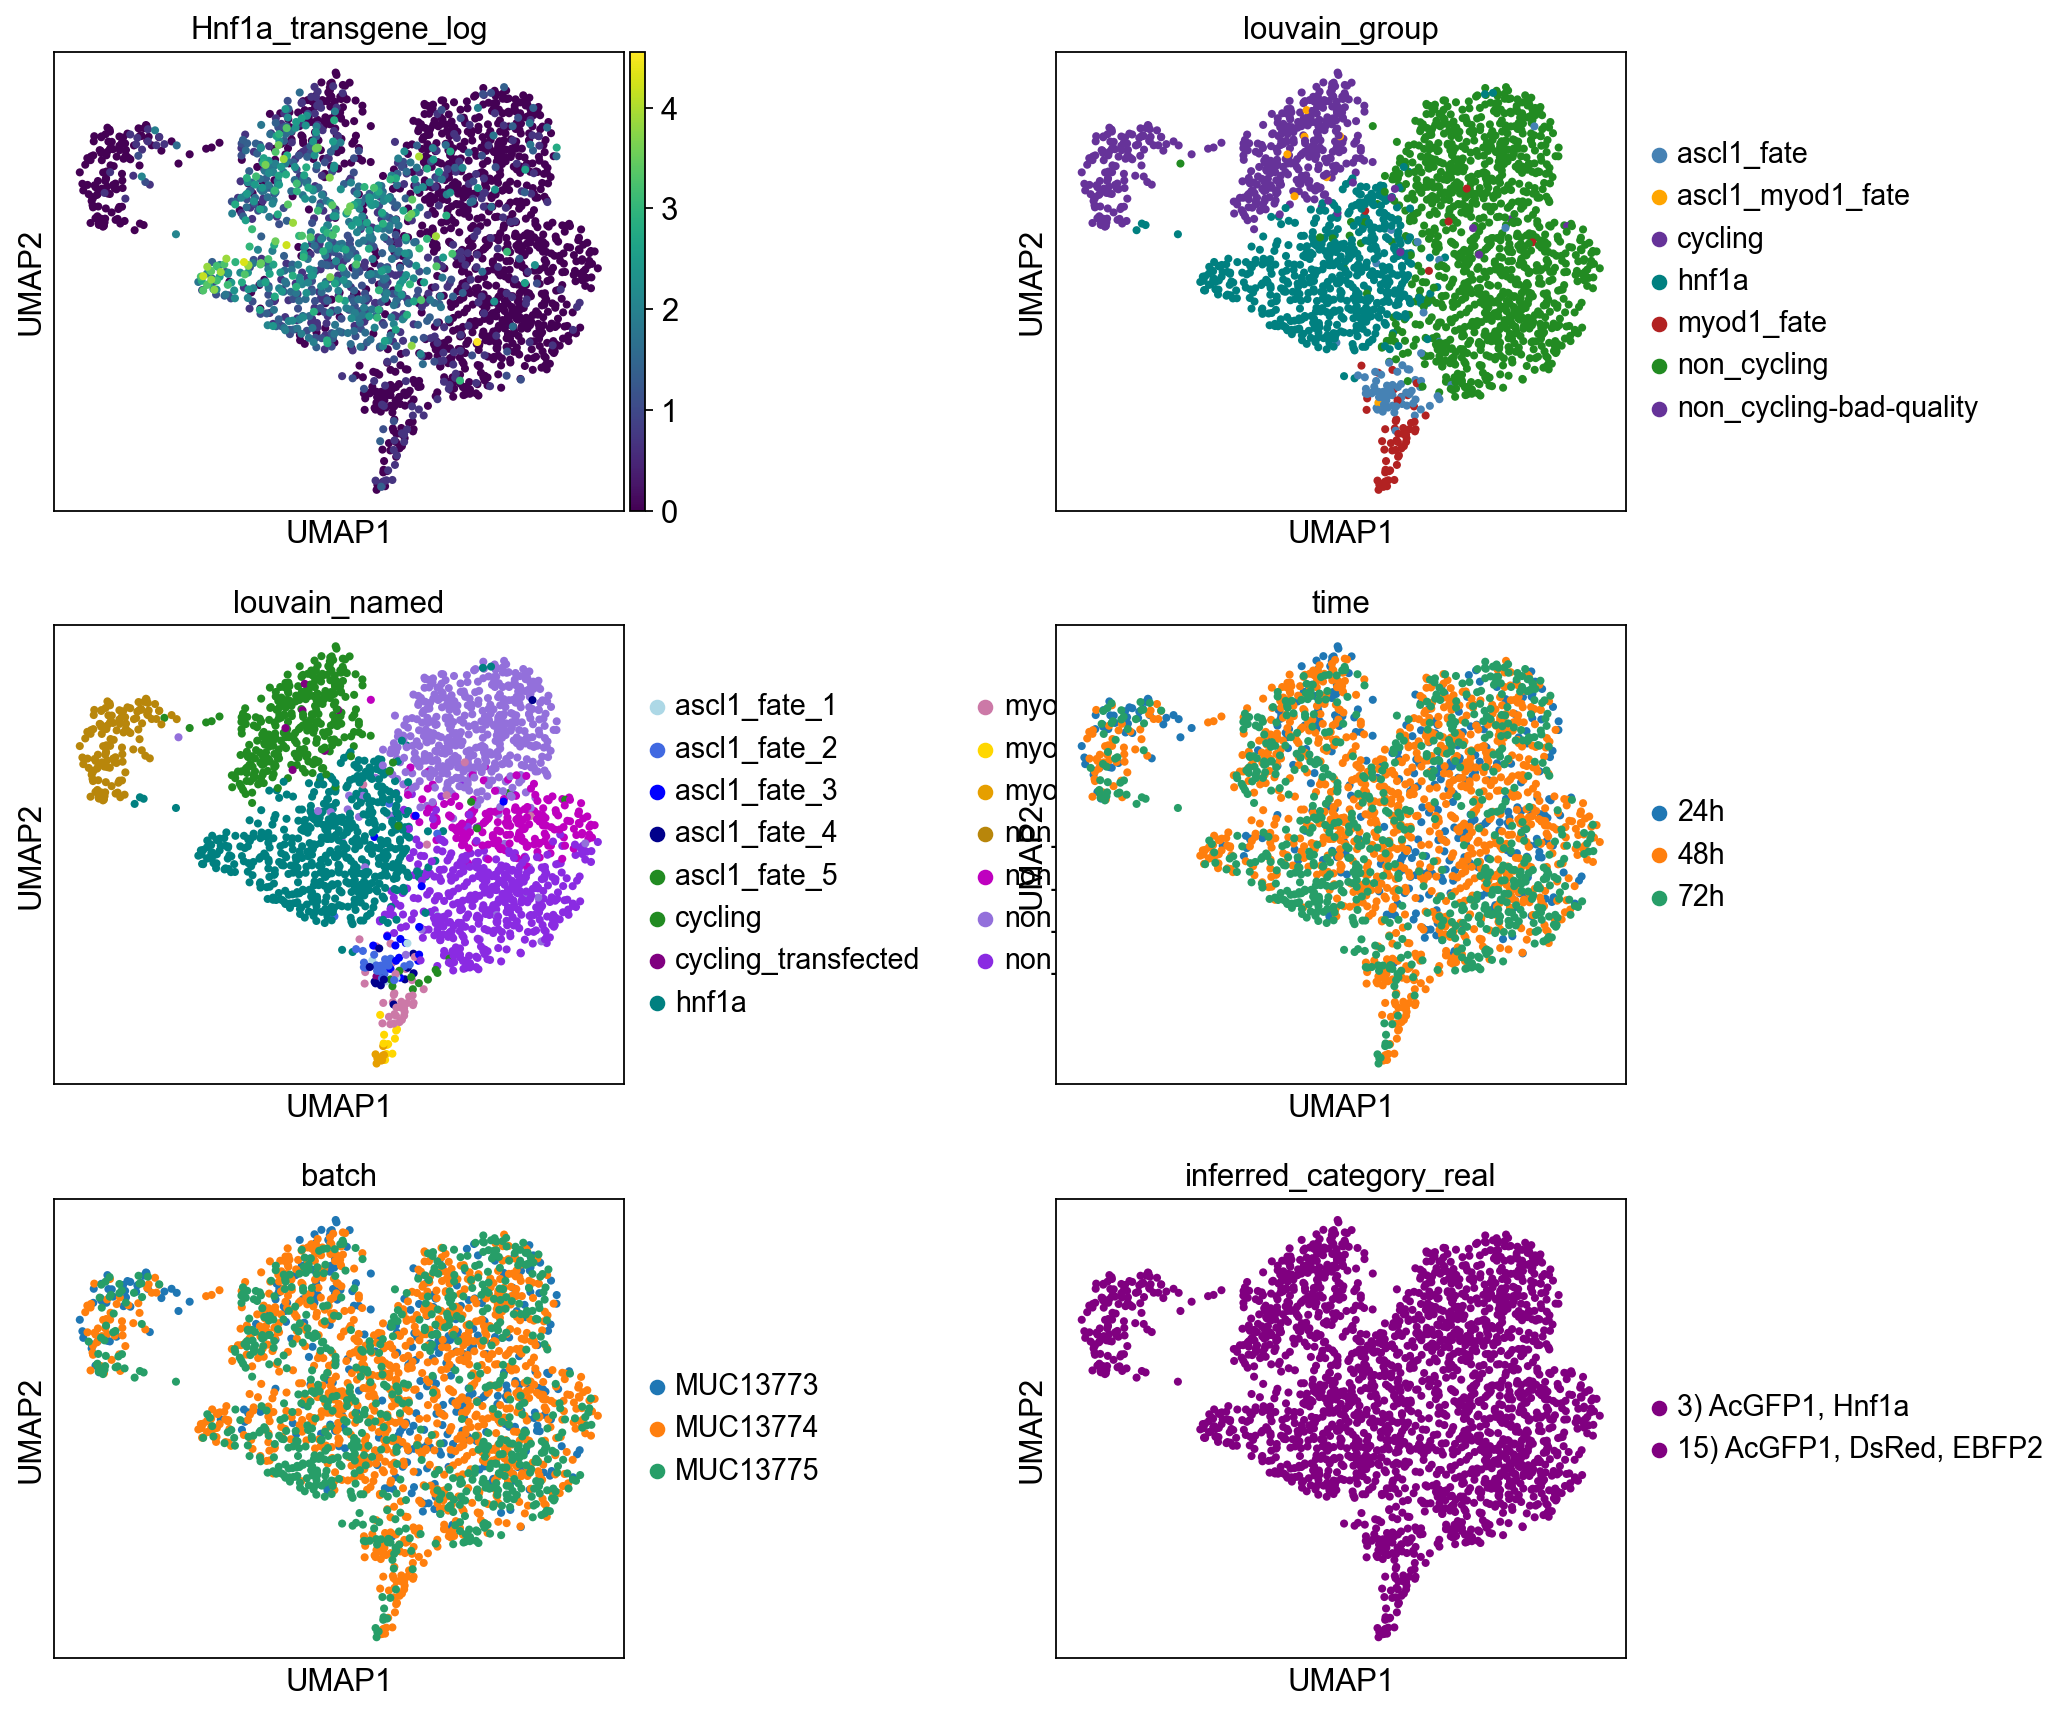

In [19]:
sc.pl.umap(adata_proc_Hnf1a, color=[
    "Hnf1a_transgene_log", 
    "louvain_group", "louvain_named",
    "time", "batch",
    "inferred_category_real"
], wspace = 0.6, ncols=2)

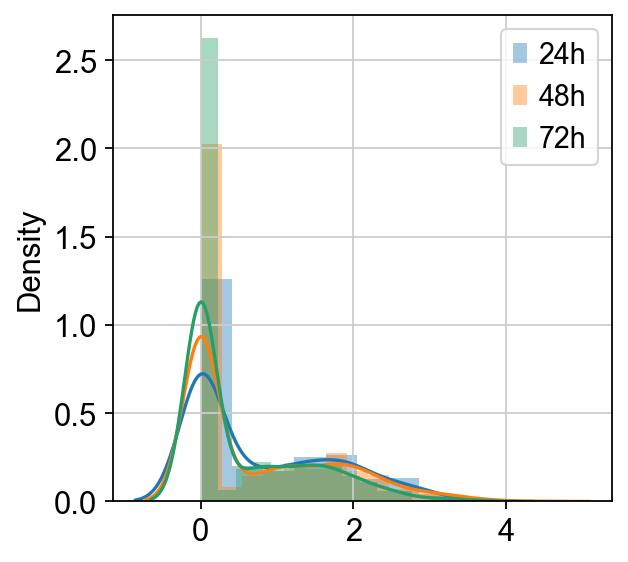

In [20]:
plot_density_along_lineage(adata=adata_proc_Hnf1a, x="Hnf1a", suffix="_transgene_norm_log_corrected")

In [21]:
Hnf1a_ref_list_up = ['pcbd1', 'pcsk9', 'smyd3', 'lrrc8d', 'il1rn', 'mgst3', 'klhdc8a', 'prkg2', 'rbpms', 'steap2', 'dkk3', 'hk2', 'f3', 'sulf1', 'hspb6']
Hnf1a_ref_list_down = ['prrx1', 'cxcl12', 'tfpi', 'mfap5', 'col6a3', 'mfap2', 'runx1t1', 'mmp23', 'gas6', 'picalm', 'atf5', 'rabggtb', 'tinagl1', 'nbeal1', 'naa20']

not found: 
[]


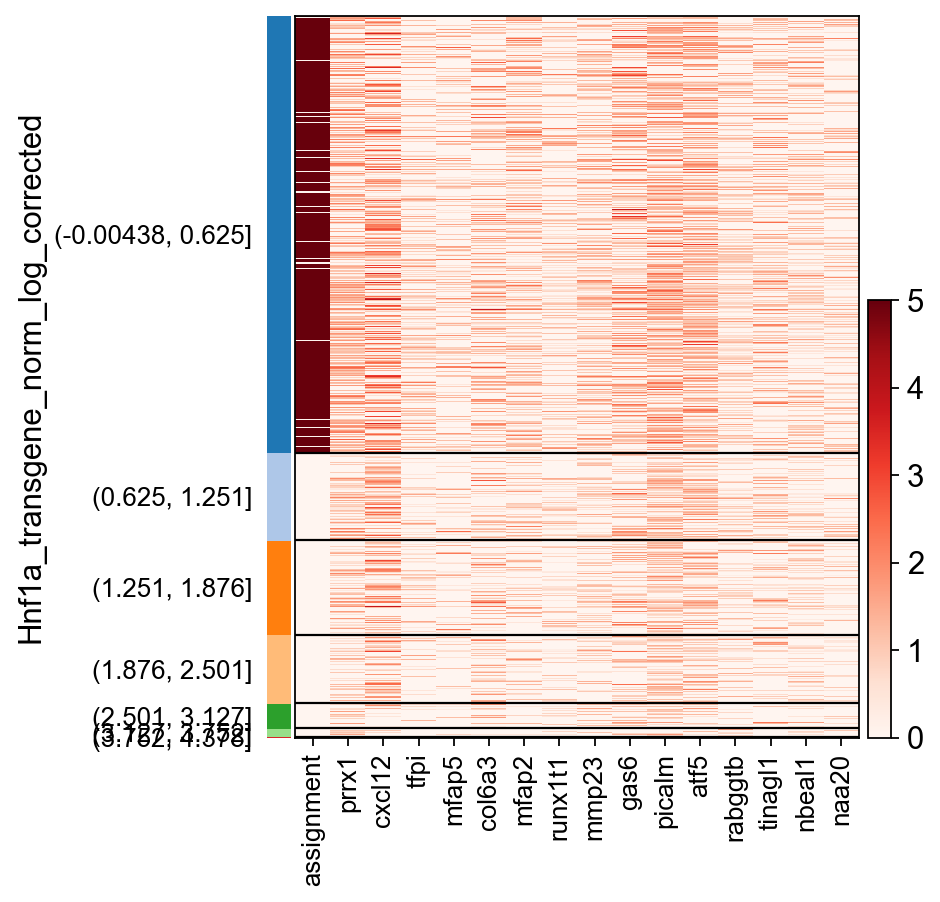

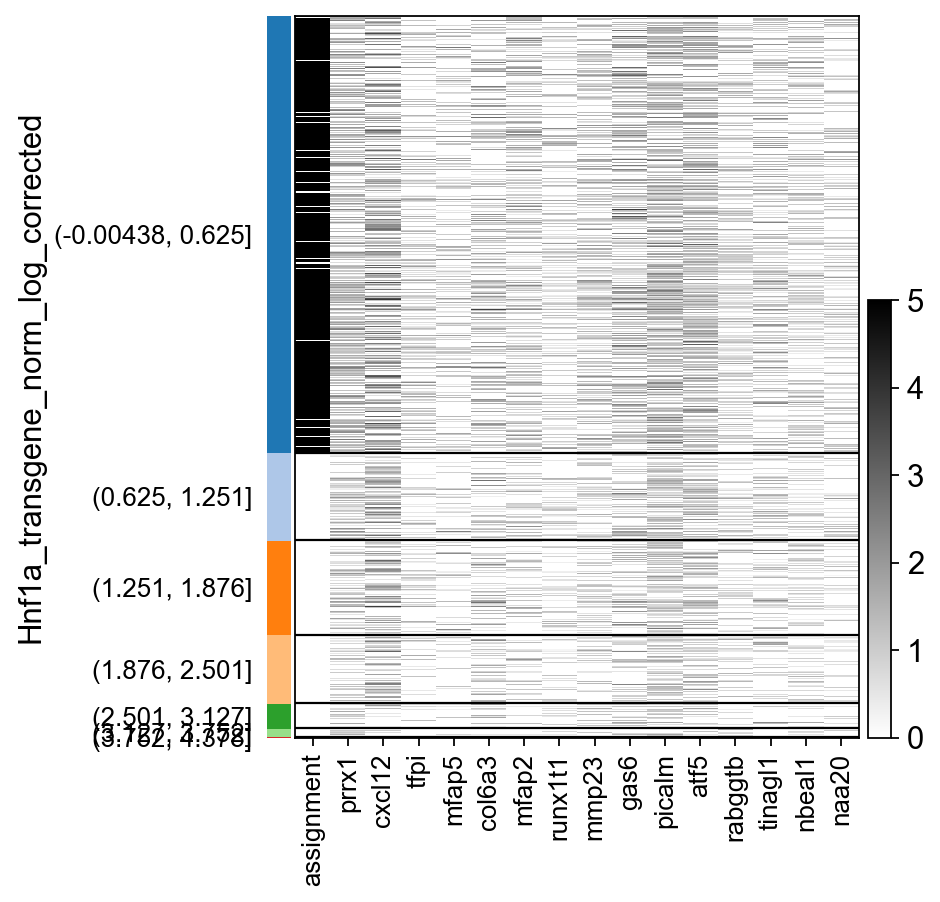

not found: 
[]


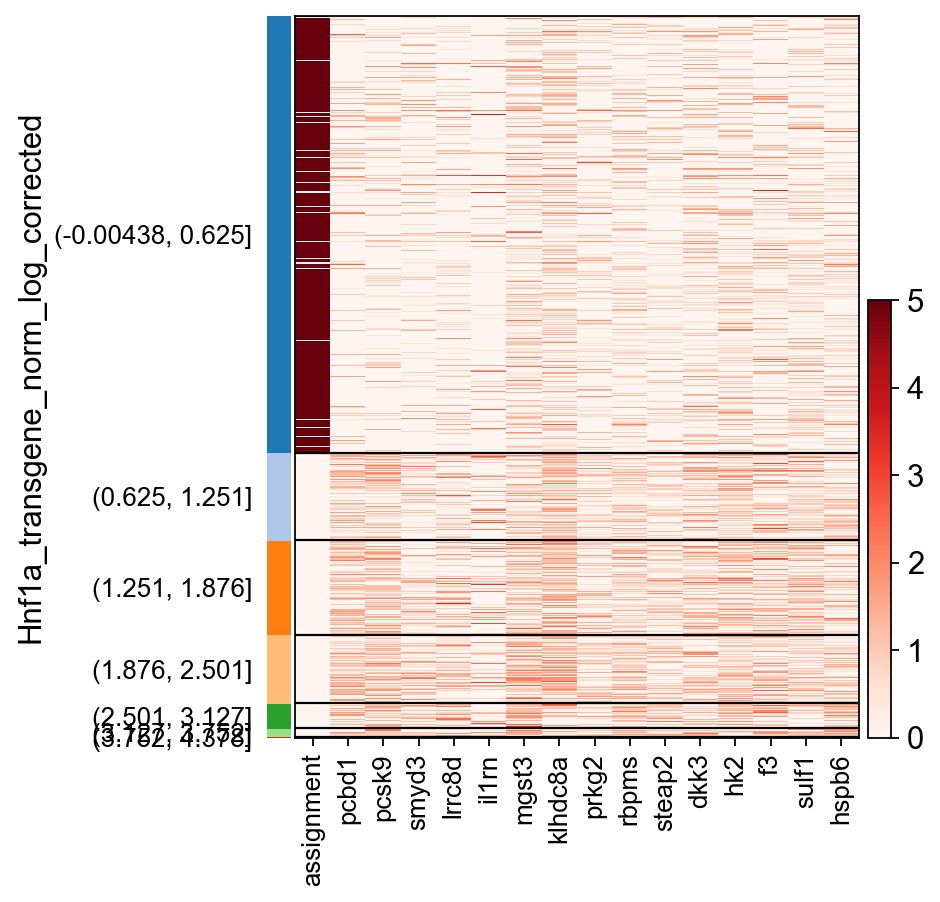

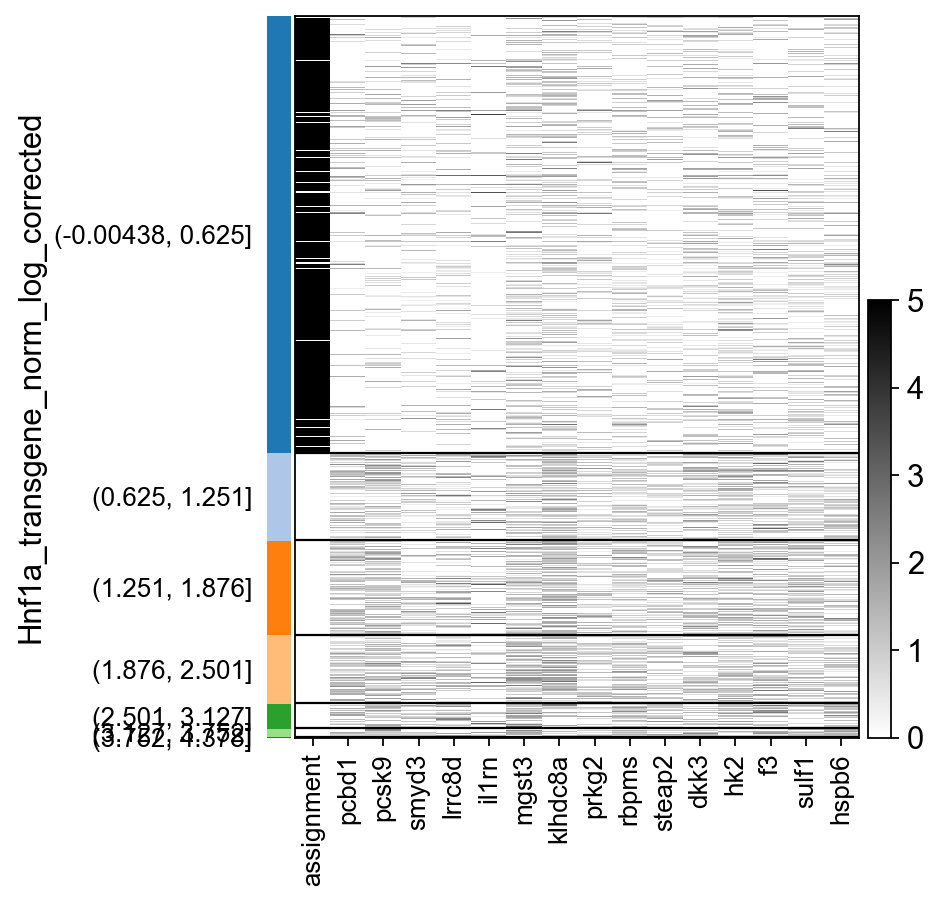

In [22]:
Hnf1a_ref_list_clean = plot_heatmap(
    adata=adata_proc_Hnf1a, 
    ref_list=Hnf1a_ref_list_down, 
    x="Hnf1a", 
    suffix="_transgene_norm_log_corrected", 
    max_log=5,
    save=None
)
Hnf1a_ref_list_clean = plot_heatmap(
    adata=adata_proc_Hnf1a, 
    ref_list=Hnf1a_ref_list_up, 
    x="Hnf1a", 
    suffix="_transgene_norm_log_corrected", 
    max_log=5,
    save=None
)

### MyoD1

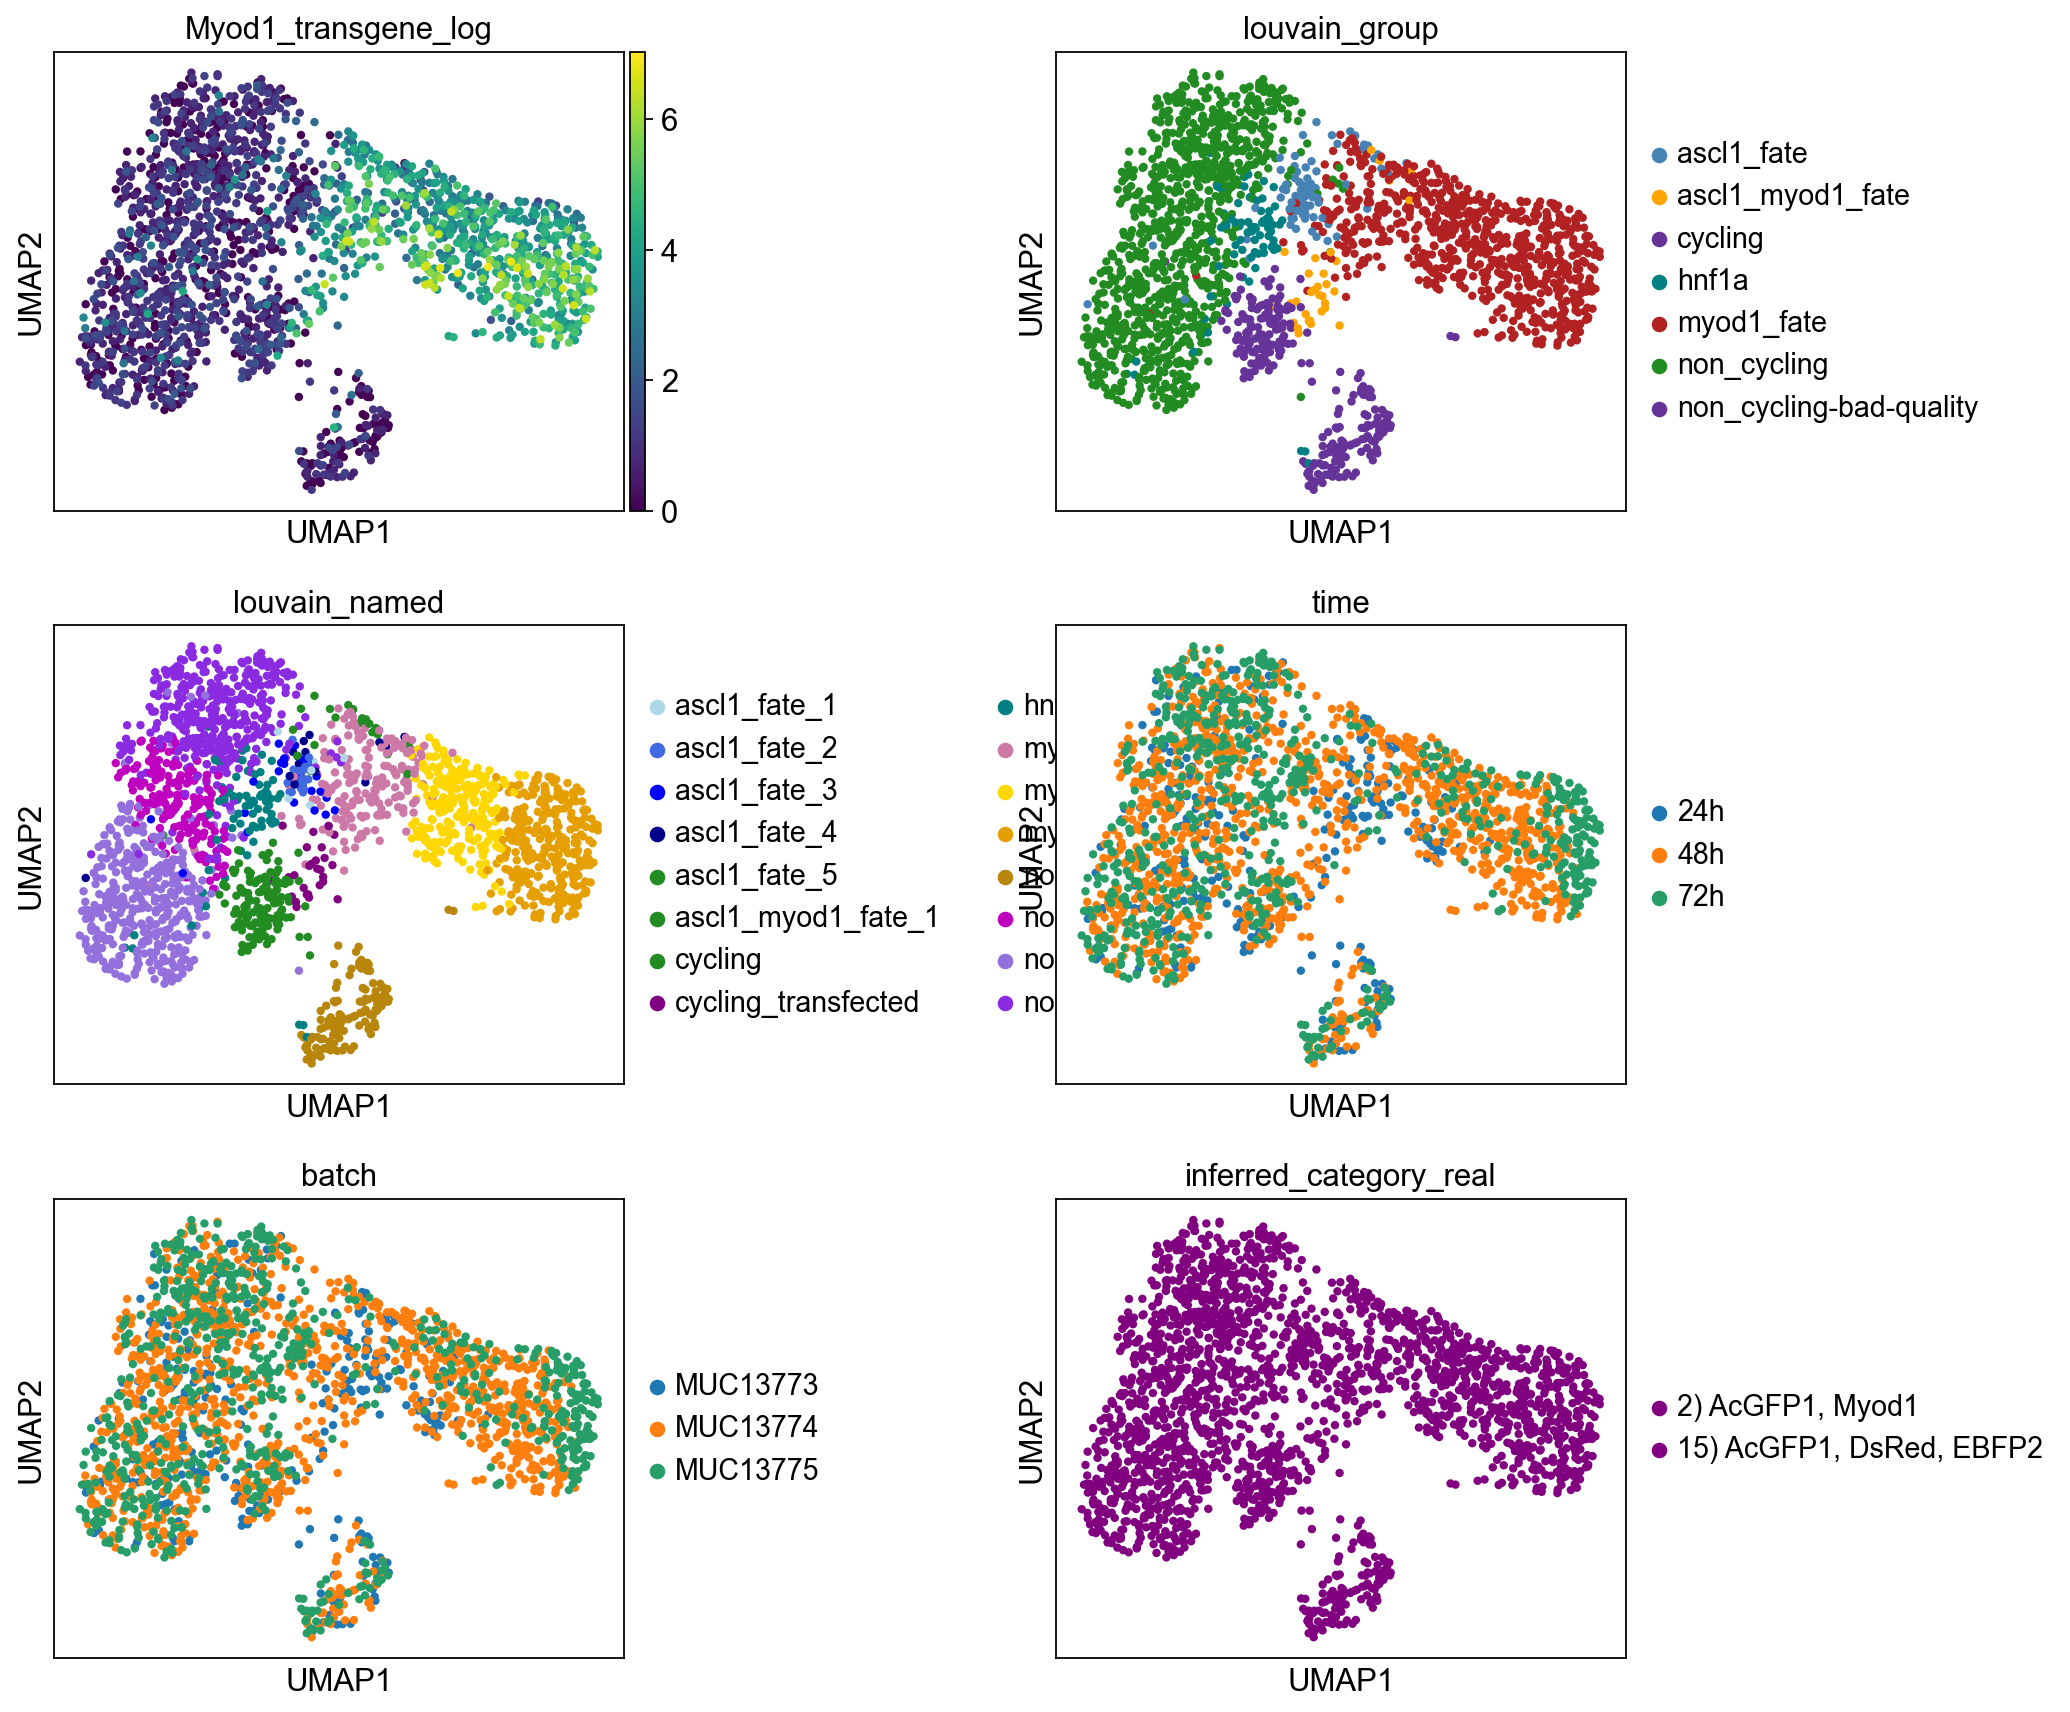

In [23]:
sc.pl.umap(adata_proc_Myod1, color=[
    "Myod1_transgene_log", 
    "louvain_group", "louvain_named", 
    "time", "batch",
    "inferred_category_real"
], wspace = 0.6, ncols=2)

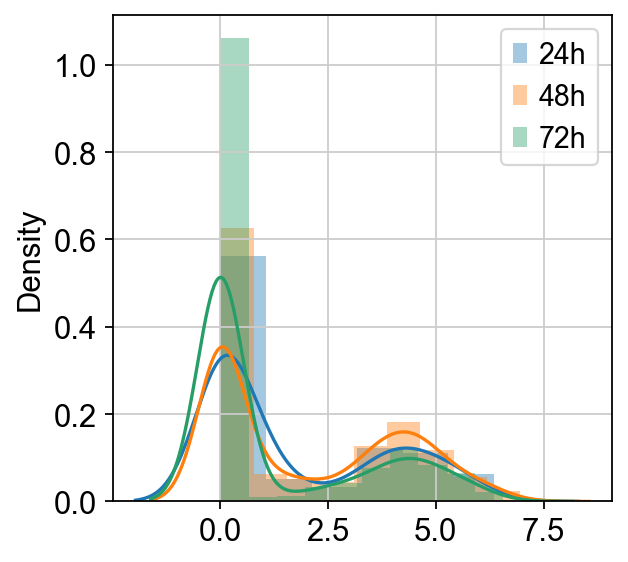

In [24]:
plot_density_along_lineage(adata=adata_proc_Myod1, x="Myod1", suffix="_transgene_norm_log_corrected")

In [25]:
MyoD1_ref_list_up = ['myl1', 'ttn', 'tnni2', 'mymk', 'actc1', 'myog', 'tnni1', 'mylpf', 'tnnt3', 'tnnt2', 'mybph', 'tnnt1', 'jsrp1', 'bex1', 'des']
MyoD1_ref_list_down = ['ngf', 'tm4sf1', 'tinagl1', 'serpine1', 'f3', 'cnn2', 'hmga2', 'plac8', 'akap12', 'col6a3', 'actg2', 'tagln2', 'fbln2', 'ccnd1', 'cav1']

not found: 
[]


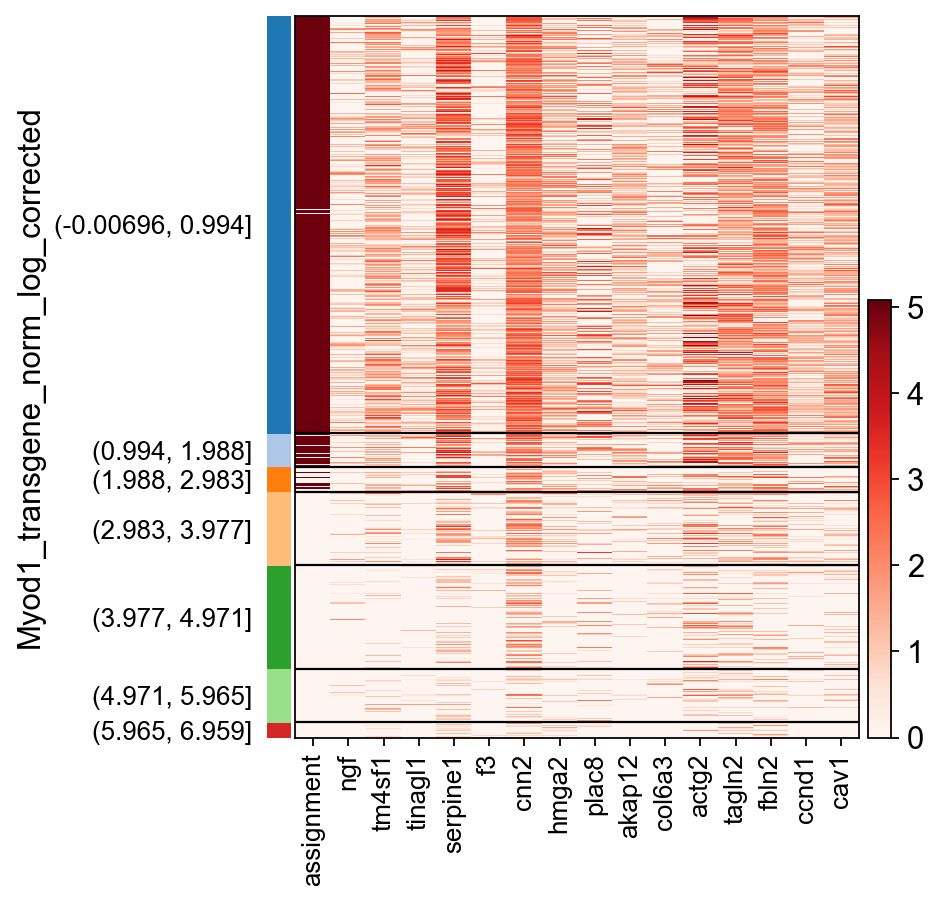

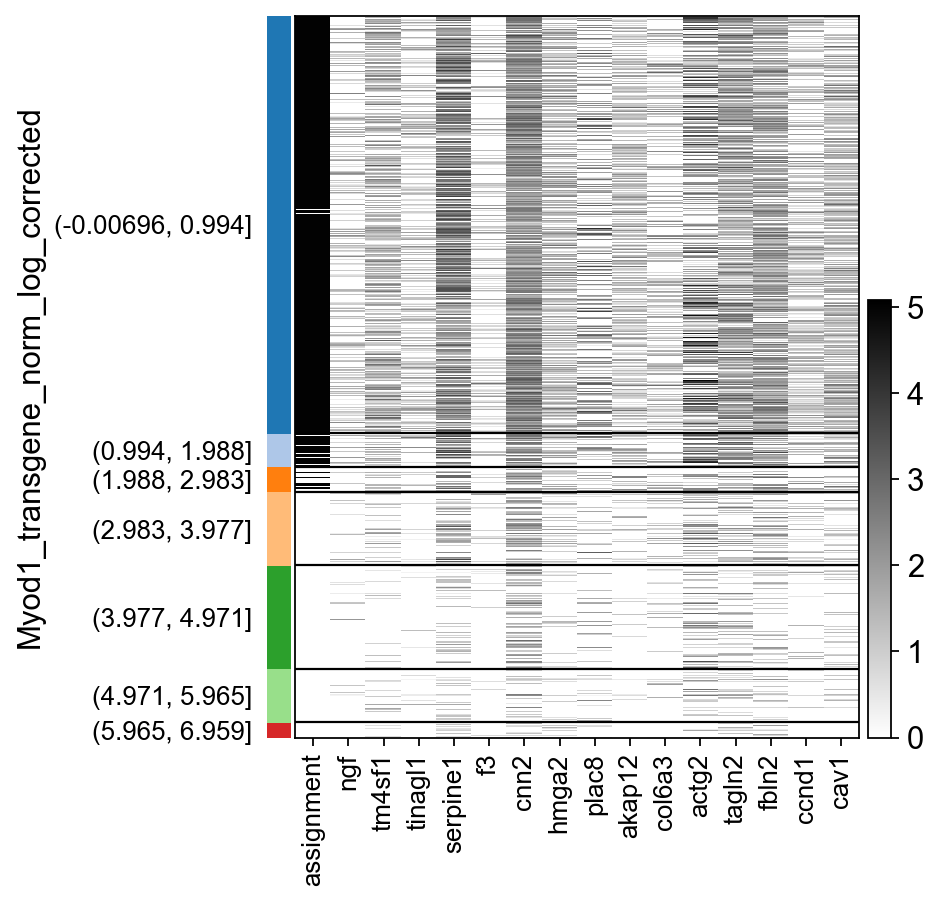

not found: 
[]


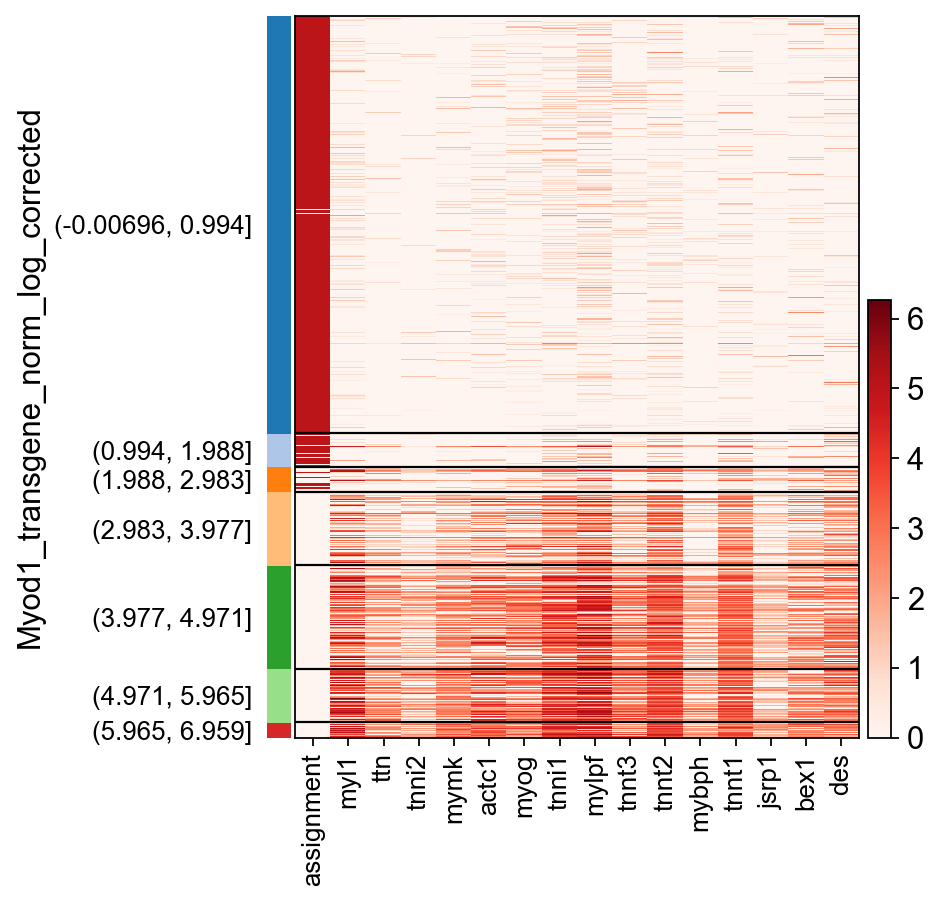

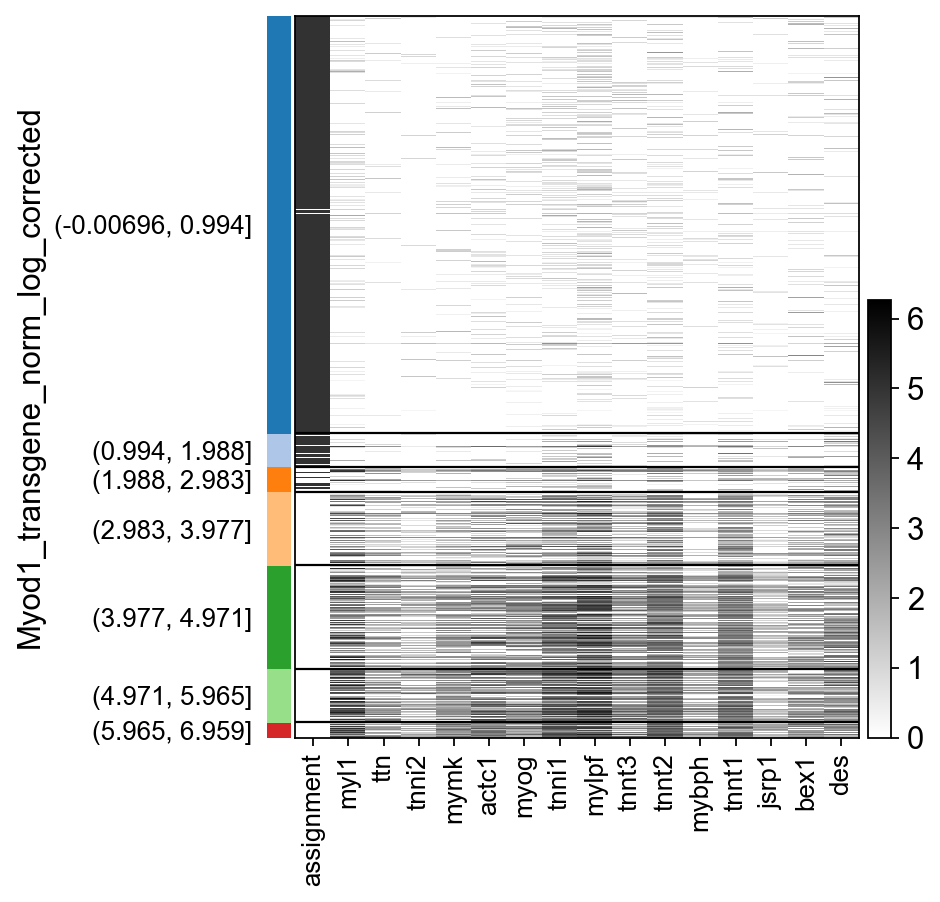

In [26]:
MyoD1_ref_list_clean = plot_heatmap(
    adata=adata_proc_Myod1, 
    ref_list=MyoD1_ref_list_down, 
    x="Myod1", 
    suffix="_transgene_norm_log_corrected", 
    max_log=5,
    save=None
)
MyoD1_ref_list_clean = plot_heatmap(
    adata=adata_proc_Myod1, 
    ref_list=MyoD1_ref_list_up, 
    x="Myod1", 
    suffix="_transgene_norm_log_corrected", 
    max_log=5,
    save=None
)

### Oct4

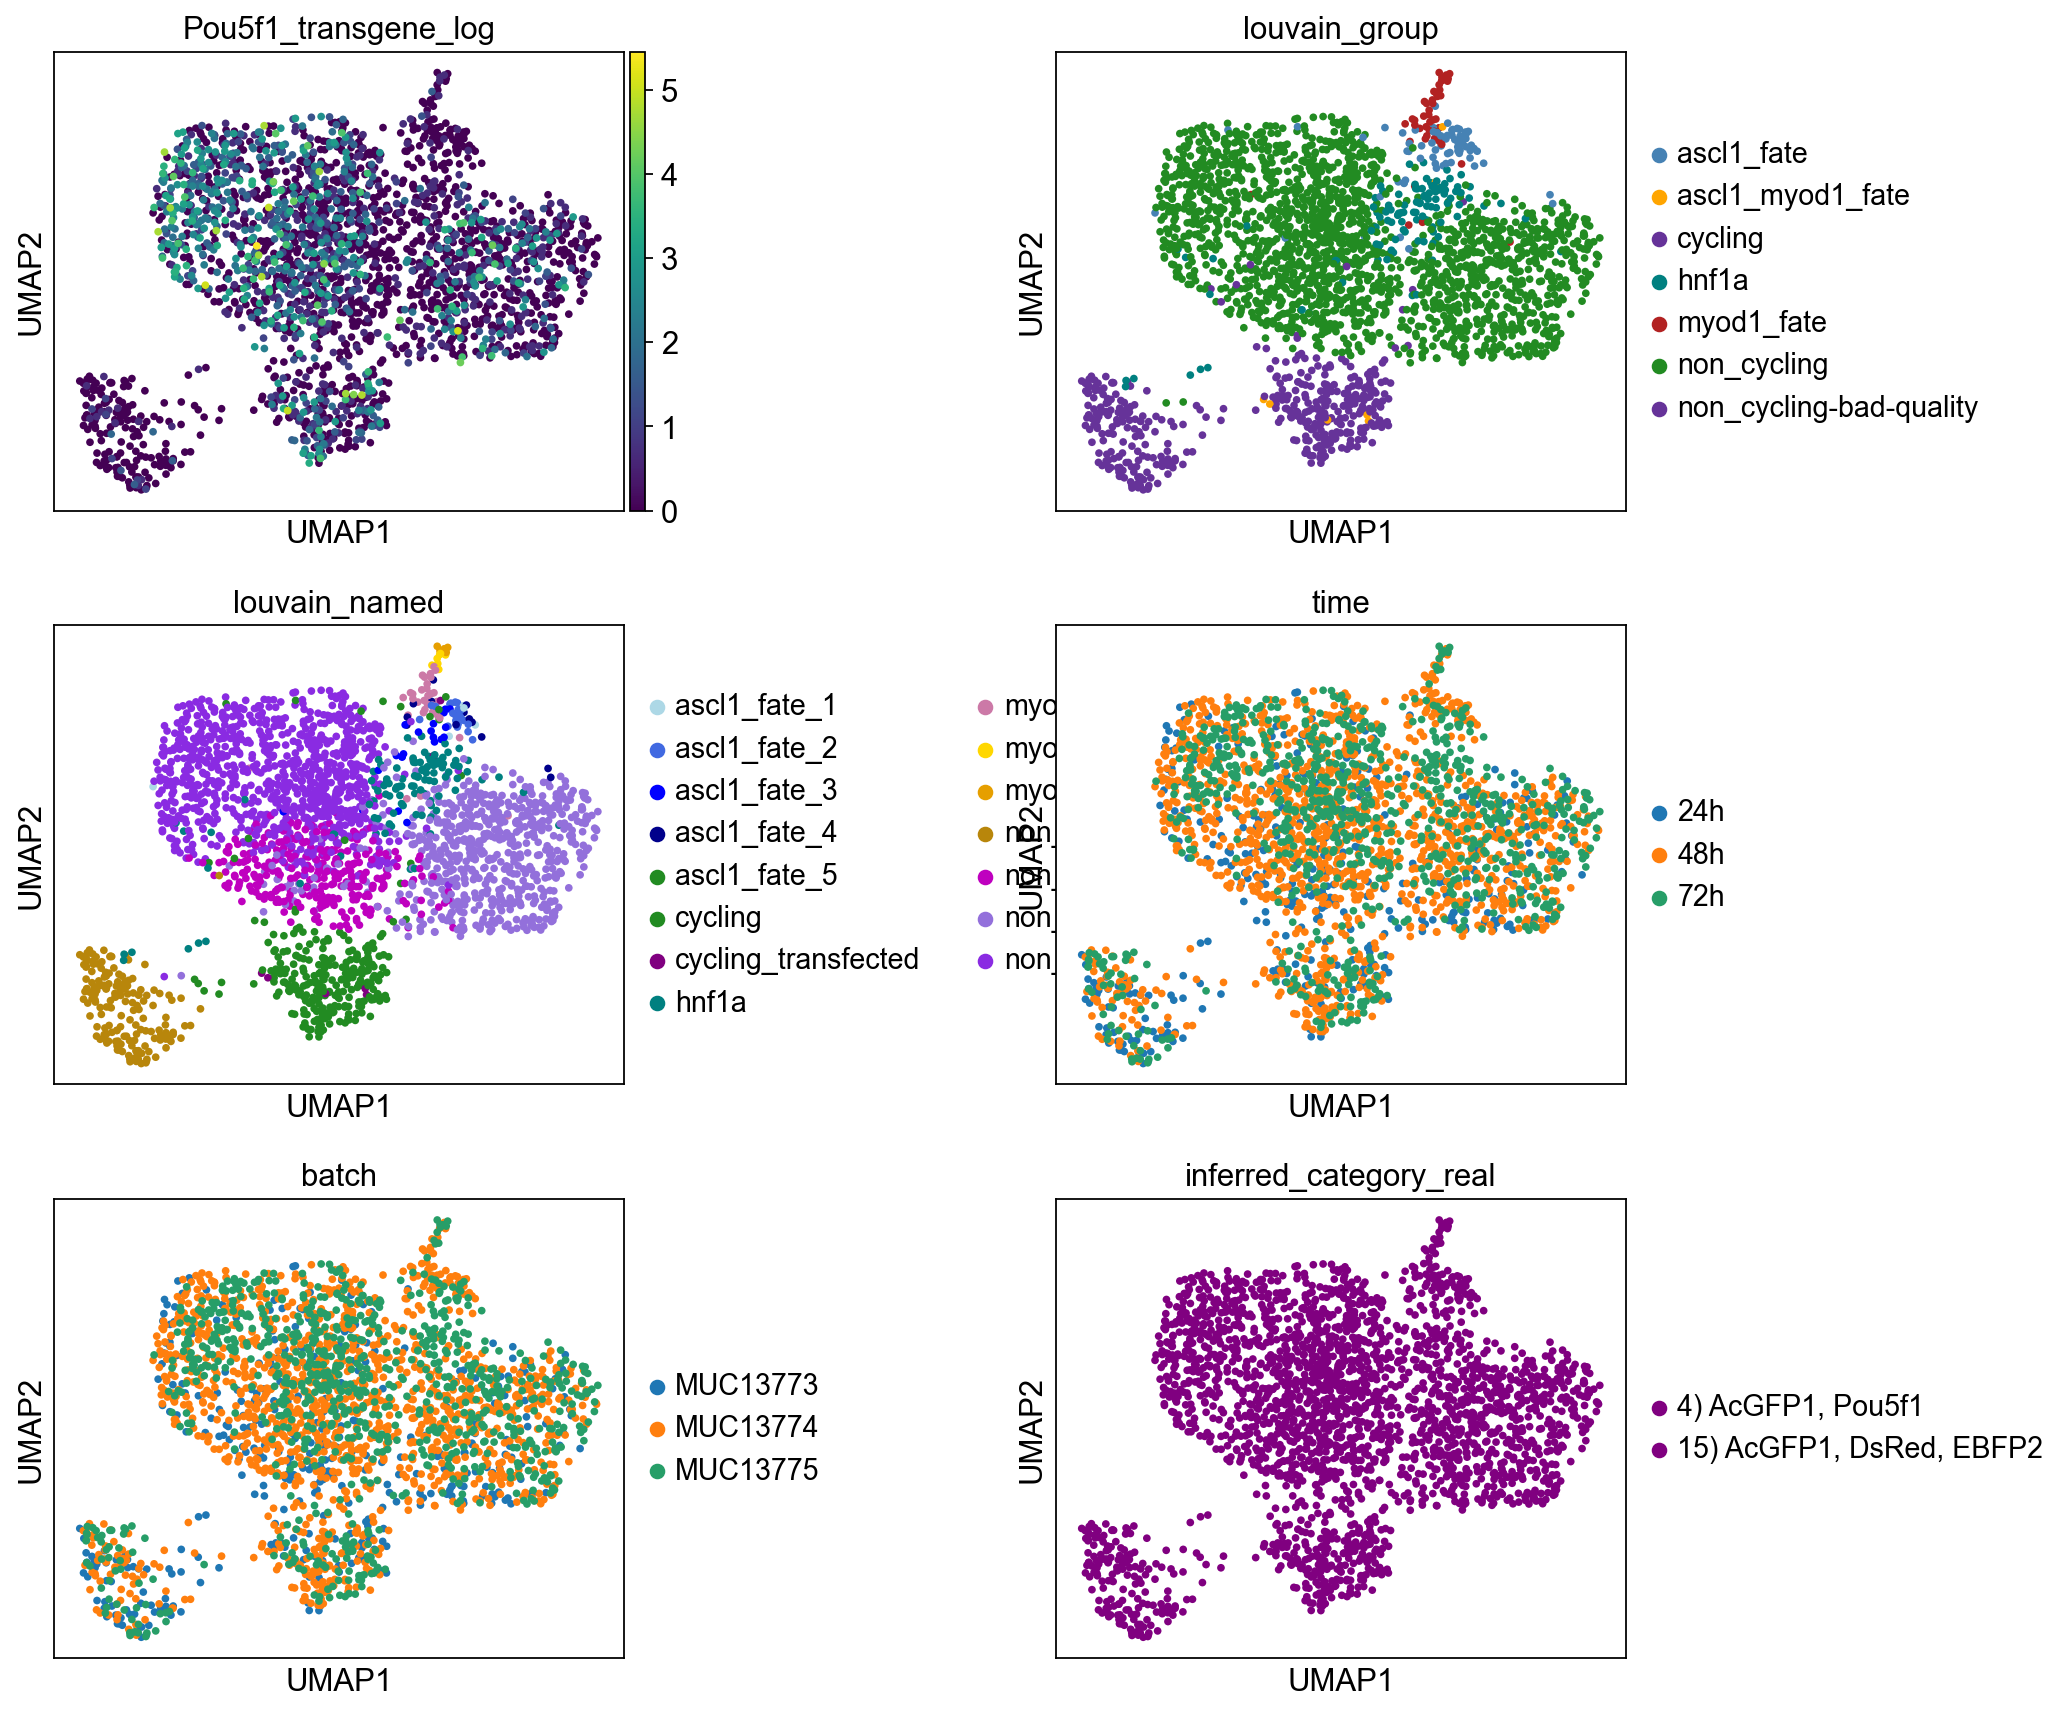

In [27]:
sc.pl.umap(adata_proc_Oct4, color=[
    "Pou5f1_transgene_log",
    "louvain_group", "louvain_named",
    "time", "batch",
    "inferred_category_real"
], wspace = 0.6, ncols=2)

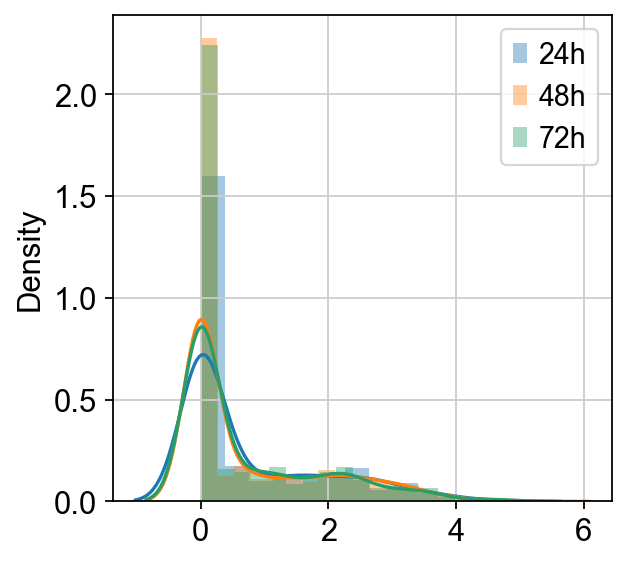

In [28]:
plot_density_along_lineage(adata=adata_proc_Oct4, x="Pou5f1", suffix="_transgene_norm_log_corrected")

In [29]:
Oct4_ref_list = [
    'vamp7', 'alkal1'
]

not found: 
[]


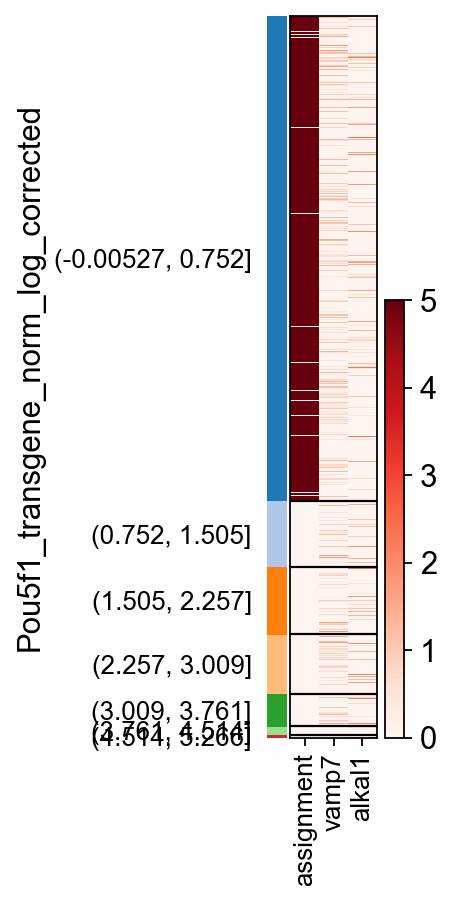

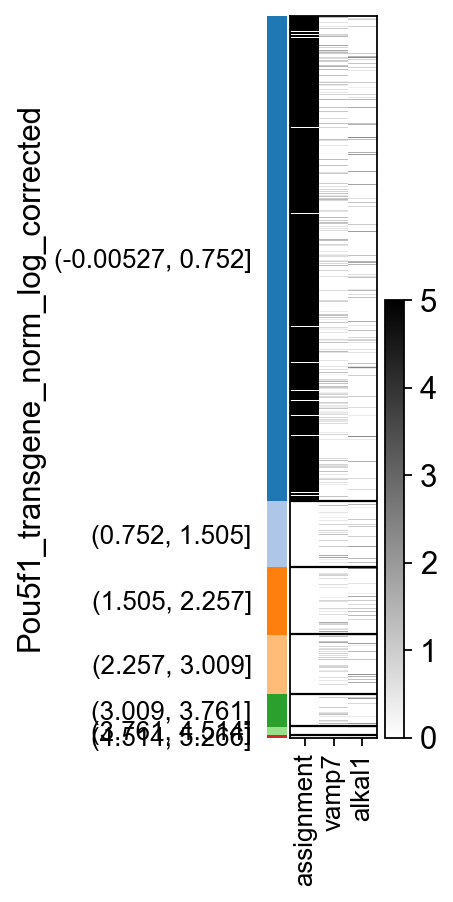

In [30]:
Oct4_ref_list_clean = plot_heatmap(
    adata=adata_proc_Oct4, 
    ref_list=Oct4_ref_list, 
    x="Pou5f1", 
    suffix="_transgene_norm_log_corrected", 
    max_log=5,
    save=None
)